## Semantic Segmentation

#### 1. Import Modules

In [1]:
%matplotlib inline

import os.path
import warnings
import re
import random
import helper
import time
import cv2
import scipy

import tensorflow as tf
import numpy as np
import project_tests as tests
import matplotlib.pyplot as plt

from glob import glob
from distutils.version import LooseVersion
from skimage import io
from skimage.transform import resize

from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model, load_model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, Lambda, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [ ]:
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

#### 2. Define functions

In [2]:
def load_vgg(image_shape=None, include_top=True):
    """
    Load Pretrained VGG Model into Keras.
    :param image_shape: Tuple of input image shape
    :param include_top: Boolean of whether to include FC layers 
    :return: Keras model instance
    """
    model = VGG16(include_top=include_top, weights='imagenet', input_shape=image_shape)
    return model

In [3]:
def layers(base_model, num_classes, beta, keep_prob):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param base_model: loaded VGG model with FC layers removed
    :param num_classes: Number of classes to classify
    :param beta: regularization constant
    :param keep_prob: probability for dropout
    :return: Keras VGG-FCN8 model with pre-trained layers frozen
    """

    l3_scale = 1e-4
    l4_scale = 1e-2

    layer3_out = base_model.get_layer('block3_pool').output
    layer4_out = base_model.get_layer('block4_pool').output

    layer3 = Conv2D(num_classes, 1, strides=(1,1), padding='same', activation='relu', 
                        kernel_regularizer=l2(beta), name='block3_1')(layer3_out)

    layer4 = Conv2D(num_classes, 1, strides=(1,1), padding='same', activation='relu', 
                        kernel_regularizer=l2(beta), name='block4_1')(layer4_out)
    
    # https://discussions.udacity.com/t/here-is-some-advice-and-clarifications-about-the-semantic-segmentation-project/403100
    layer3_scale = Lambda(lambda x: (x * l3_scale) , name = 'block3_1_scaled')(layer3)
    layer4_scale = Lambda(lambda x: (x * l4_scale) , name = 'block4_1_scaled')(layer4)

    x = base_model.output
    x = Conv2D(4096, 7, strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(beta), name='fc6_1x1')(x)
    x = Dropout(keep_prob)(x)
    x = Conv2D(4096, 1, strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(beta), name='fc7_1x1')(x)
    x = Dropout(keep_prob)(x)
    x = Conv2D(num_classes, 1, strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(beta), name='fc7_nclasses')(x)
    x = Conv2DTranspose(num_classes, 4, strides=(2,2), padding='same', activation='relu', 
                        kernel_regularizer=l2(beta), name='block4_2')(x)
    x = Add(name='Skip1')([x, layer4_scale])
    x = Conv2DTranspose(num_classes, 4, strides=(2,2), padding='same', activation='relu', 
                        kernel_regularizer=l2(beta), name='block3_2')(x)
    x = Add(name='Skip2')([x, layer3_scale])

    predictions = Conv2DTranspose(num_classes, 16, strides=(8,8), padding='same', activation='softmax', name='output')(x)

    final_model = Model(inputs=base_model.input, outputs=predictions)
    #Freeze base_model layers
    for layer in base_model.layers:
        layer.trainable = False
    final_model.summary()

    return final_model

In [4]:
def optimize(model, learning_rate):
    """
    Build the TensorFLow loss and optimizer operations.
    :param model: Keras model instance
    :param learning_rate: learning rate [float]
    :param y_true: NumPy array of true labels
    :return: None
    """
    # https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
    # ref: https://arxiv.org/pdf/1606.04797v1.pdf
    def dice_coeff(y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(K.abs(y_true_f * y_pred_f))
        return 2*(intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

    def dice_loss(y_true, y_pred):
        return 1-dice_coeff(y_true, y_pred)
    
    #model.compile(optimizer=Adam(lr=learning_rate), loss=dice_loss, metrics=[dice_coeff])
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
def train_nn(model, epochs, n_batches, data_generator, model_dir):
    """
    Train neural network and print out the loss during training.
    :param model: Keras model instance to train
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    """
    model_file = os.path.join(model_dir, 'vgg_fcn8.{epoch:02d}-{loss:.3f}.h5')
    t = time.time()
    checkpoint = ModelCheckpoint(model_file, verbose=1, save_best_only=False, period=1)
    TrainingCallbacks = [checkpoint]
    training_history = model.fit_generator(data_generator, steps_per_epoch=n_batches, epochs=epochs, verbose=2, 
                                           callbacks=TrainingCallbacks, validation_data=None, validation_steps=None)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train model...')
    
    return training_history

#### 3. Build & train the model

In [6]:
num_classes = 2
beta = 1e-3
batch_size = 2
image_shape = (160, 576, 3)
epochs = 15
learning_rate = 1e-3
keep_prob = 0.5
#data_dir = os.path.join('d:\\')
data_dir = os.path.join('c:\\', 'data')
runs_dir = os.path.join('.','runs')
model_dir = os.path.join('.','model')

In [7]:
vgg_encoder = load_vgg(image_shape, include_top=False)

In [8]:
vgg_fcn8 = layers(vgg_encoder, num_classes, beta, keep_prob)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 576, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 288, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [9]:
optimize(vgg_fcn8, learning_rate)

In [10]:
#Number of training images & batches
n_train_images = len(glob(os.path.join(data_dir, 'data_road', 'training', 'image_2', '*.png')))
n_batches = -(-n_train_images//batch_size)

# Create function to get batches
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road', 'training'), image_shape[:2])
data_generator = get_batches_fn(batch_size)
# Train NN using the train_nn function
training_history = train_nn(vgg_fcn8, epochs, n_batches, data_generator, model_dir)

Epoch 1/15
 - 84s - loss: 0.7394 - acc: 0.7742

Epoch 00001: saving model to .\model\vgg_fcn8.01-0.741.h5
Epoch 2/15
 - 70s - loss: 0.3828 - acc: 0.8880

Epoch 00002: saving model to .\model\vgg_fcn8.02-0.383.h5
Epoch 3/15
 - 69s - loss: 0.3153 - acc: 0.9209

Epoch 00003: saving model to .\model\vgg_fcn8.03-0.316.h5
Epoch 4/15
 - 69s - loss: 0.2968 - acc: 0.9293

Epoch 00004: saving model to .\model\vgg_fcn8.04-0.297.h5
Epoch 5/15
 - 70s - loss: 0.2933 - acc: 0.9327

Epoch 00005: saving model to .\model\vgg_fcn8.05-0.293.h5
Epoch 6/15
 - 69s - loss: 0.2873 - acc: 0.9337

Epoch 00006: saving model to .\model\vgg_fcn8.06-0.287.h5
Epoch 7/15
 - 70s - loss: 0.2643 - acc: 0.9358

Epoch 00007: saving model to .\model\vgg_fcn8.07-0.264.h5
Epoch 8/15
 - 70s - loss: 0.2622 - acc: 0.9366

Epoch 00008: saving model to .\model\vgg_fcn8.08-0.262.h5
Epoch 9/15
 - 70s - loss: 0.2589 - acc: 0.9372

Epoch 00009: saving model to .\model\vgg_fcn8.09-0.258.h5
Epoch 10/15
 - 70s - loss: 0.2369 - acc: 0.938

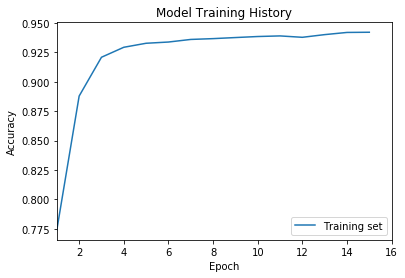

In [11]:
#Visualize the training and validation loss
plt.plot(np.arange(1,epochs+1,1), training_history.history['acc'])
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([1,epochs+1])
plt.legend(['Training set', 'Validation set'], loc='lower right')
plt.savefig(os.path.join('training_history_L2reg.png'))
plt.show()

#### 4. Make Predictions

In [12]:
vggfcn8_loaded = load_model(os.path.join(model_dir, 'vgg_fcn8.15-0.235.h5'))

In [13]:
test_files = glob(os.path.join(data_dir, 'data_road', 'testing', 'image_2', '*.png'))
n_test_images = len(test_files)
test_batch_size = 4
n_test_batches = -(-n_test_images//test_batch_size)

In [14]:
test_images = np.zeros([n_test_images, *image_shape])
for index, file in enumerate(test_files):
    test_images[index] = resize(io.imread(file), image_shape)

C:\Users\razas\AppData\Local\conda\conda\envs\deep-learn\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
masks = vggfcn8_loaded.predict(test_images, batch_size=4, verbose=1)

290/290 [==============================] - ETA: 1: - ETA: 39s - ETA: 30 - ETA: 26 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 15s 53ms/step


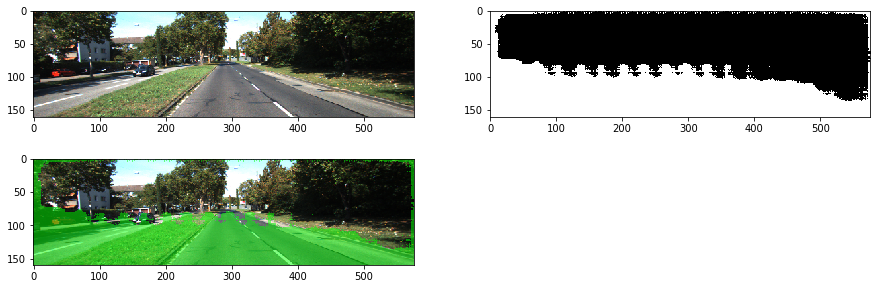

In [28]:
index = 10
sample = test_images[index]
mask = masks[index]

#mask_filler = np.zeros_like(mask[:,:,1], dtype=np.float64)
#mask_RGB = np.dstack([mask_filler, mask[:,:,1], mask_filler])
#masked_image = cv2.addWeighted(sample, 1.0, mask_RGB, 0.5, 0)


segmentation = (mask[:,:,1] > 0.5).reshape(image_shape[0], image_shape[1], 1)
mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
mask = scipy.misc.toimage(mask, mode="RGBA")
street_im = scipy.misc.toimage(sample)
street_im.paste(mask, box=None, mask=mask)
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.imshow(sample)
plt.subplot(2,2,2)
plt.imshow(segmentation[:,:,0], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(street_im)
plt.show()